In [ ]:
# TODO
spec, *_ = plt.specgram(np.diff(letters[0,11,8]), NFFT=512, noverlap=0);
plt.yticks(np.arange(0, 250, 10))
plt.imshow(np.log(spec), origin='lower', aspect='auto')
plt.plot(np.log10(spec.sum(axis=0)))
# Pretty good way to find non-stroke sounds:
cutoff = 22
plt.plot(np.min(spec[150:], axis=0) / np.max(spec[:cutoff], axis=0))

In [1]:
import numpy as np

def block_audio(x, blockSize, hopSize):
    numBlocks = (x.size - blockSize) // hopSize
    xb = np.empty((numBlocks, blockSize))
    for i in range(numBlocks):
        xb[i] = x[i*hopSize:i*hopSize + blockSize]
    return xb

def get_power(x):
    xb = block_audio(np.diff(x), 2048, 512)
    return np.log10(np.maximum((xb**2).mean(axis=1), 1e-10)) * 10

In [60]:
import warnings
import matplotlib.pyplot as plt
from matplotlib import mlab
import scipy.io.wavfile
import scipy.signal

def extract(subject, letter, win_start, win_end, hop_factor=0.7, height=0.015, manual=[], embed_audio=False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fs, data = scipy.io.wavfile.read(f"letter_runs/{subject+1}-{letter}-PZ.wav")
    if len(data.shape) > 1:
        data = data[:, 0]
    x = data.astype(float) / np.iinfo(data.dtype).max
    power = get_power(x)
    fs /= 512
    plt.figure(figsize=(20, 4))
#     plt.plot(power)

    filtered = power
    d = (filtered - np.mean(filtered)) / np.std(filtered)
    t = np.arange(len(d)) / fs
    plt.xticks(np.arange(t[-1]))
    plt.plot(t, d - 8)
    start = int(fs*win_start)
    window = d[start:int(fs*win_end)]

    plt.plot((np.arange(len(window)) + start) / fs, window - 8)

    window = (window - np.mean(window)) / np.std(window)
    corr = scipy.signal.correlate(d, window, mode='full')[len(window)-1:] / len(d)
 
    plt.plot(t[:len(corr)], corr * 100)

    peaks = scipy.signal.find_peaks(corr, height=height)[0]
    indices = [start]
    while True:
        start = start + int(len(window)*hop_factor)
        p = peaks[peaks >= start]
        if len(p) == 0:
            break
        plt.scatter(p / fs, corr[p] * 100, c='red')
        index = p[0]
        start = index
        indices.append(index)
    
    if manual:
        indices = sorted(indices + list((np.array(manual) * fs).astype(int)))

    if len(indices) > 20:
        print(f"Dropping last {len(indices) - 20}")
        indices = indices[:20]
    print(len(indices))
    for i, (start, next_start) in enumerate(zip(indices, indices[1:] + [len(d)])):
        end = min(start + len(window), next_start)
        plt.axvline(start / fs, c='red')
        plt.axvspan(start / fs, end / fs, color='red', alpha=0.05)
        # Remove silence at the start and end, which is a problem in a couple of places due to letter_runs editing.
        nonzero = np.where(data[start:end] != 0)[0]
        end = start + nonzero[-1] + 1
        start = start + nonzero[0]    


    spec, *_ = mlab.specgram(np.diff(x), NFFT=512, noverlap=0)
    spec = spec[:, :len(t)]
    # Pretty good way to find non-stroke sounds:
    cutoff = 22
    ratio = np.min(spec[150:], axis=0) / np.max(spec[:cutoff], axis=0)
    plt.plot(t, ratio * 50 + 8)
    
    plt.figure(figsize=(20, 4))
    plt.yticks(np.arange(0, 250, 10))
    plt.imshow(np.log(spec), origin='lower', aspect='auto')

Dropping last 1
20


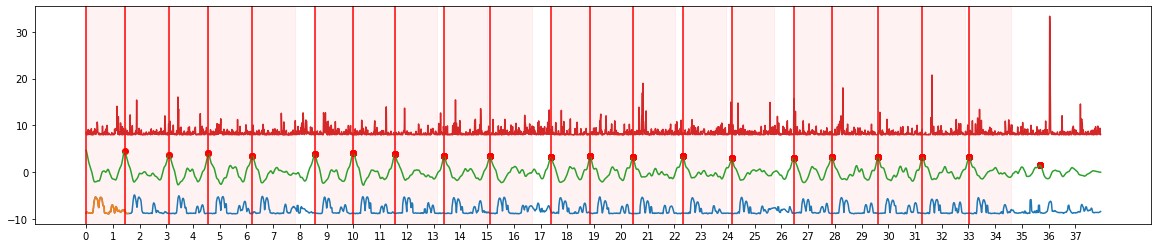

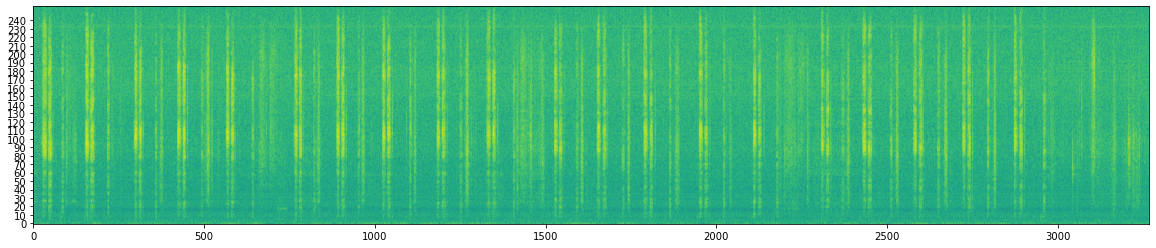

In [61]:
extract(0, "A", 0, 1.6)

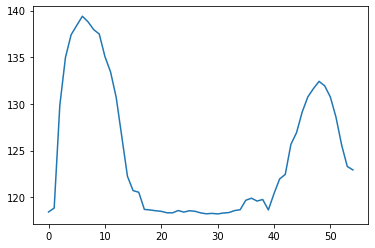

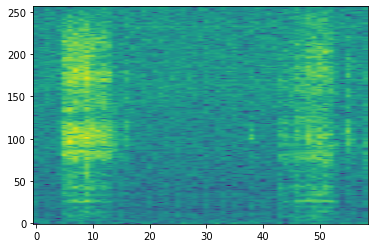

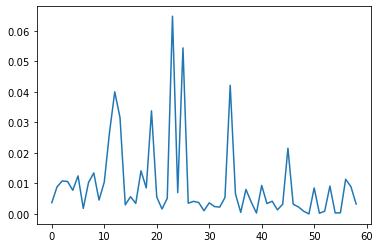

In [77]:
fs, x = scipy.io.wavfile.read(f"letters/1/T/PZ/2.wav")
x = x[10*512:70*512]
plt.plot(get_power(x))
plt.figure()
spec, *_ = mlab.specgram(np.diff(x), NFFT=512, noverlap=0)
plt.imshow(np.log(spec), origin='lower', aspect='auto')
cutoff = 22
ratio = np.min(spec[150:], axis=0) / np.max(spec[:cutoff], axis=0)
plt.figure()
plt.plot(ratio)
from IPython.display import Audio
display(Audio(x, rate=fs))

scipy.io.wavfile.write(f"good/T.wav", fs, x)

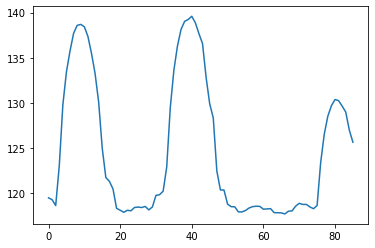

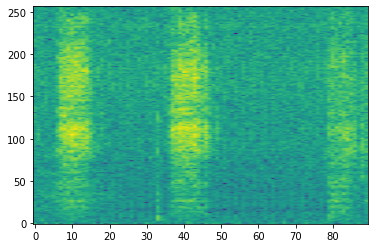

In [85]:
fs, x = scipy.io.wavfile.read(f"letters/1/H/PZ/2.wav")
x = x[35*512:126*512]
plt.plot(get_power(x))
plt.figure()
spec, *_ = mlab.specgram(np.diff(x), NFFT=512, noverlap=0)
plt.imshow(np.log(spec), origin='lower', aspect='auto')
display(Audio(x, rate=fs))

scipy.io.wavfile.write(f"good/H.wav", fs, x)

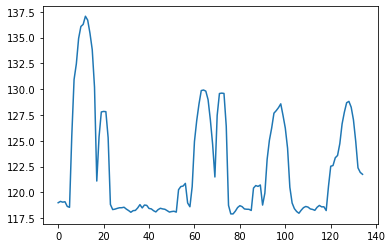

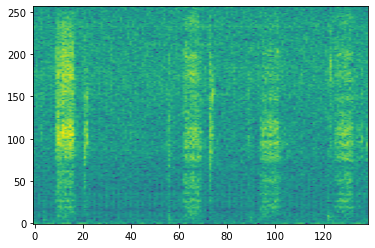

In [90]:
fs, x = scipy.io.wavfile.read(f"letters/1/E/PZ/2.wav")
x = x[25*512:165*512]
plt.plot(get_power(x))
plt.figure()
spec, *_ = mlab.specgram(np.diff(x), NFFT=512, noverlap=0)
plt.imshow(np.log(spec), origin='lower', aspect='auto')
display(Audio(x, rate=fs))

scipy.io.wavfile.write(f"good/E.wav", fs, x)